In [1]:
%load_ext autoreload
%autoreload 2

In [169]:
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle

from src.embeddings import get_embedding_dictionnary, get_embeddings_and_word_index, sequences_to_index
from src.dataset import load_dataset, load_datasets_and_vocab_pipeline, train_test_val_split
from src.evaluate import get_metrics, get_predictions, compare_metrics, get_metrics_binary
from src.models import model_mine, model_conv1d, EnsembleModel
from src.submission import generate_predictions
from src.model_saverloader import *
from src.utils import get_wrongs

embeddings_path = '../sentiment_analysis/data/embeddings/datastories.twitter.300d.txt'

### Load and preprocess Train and Test

In [3]:
(X_train_txt, y_train), (X_test_txt, y_test), (vocab, max_seq_len) = load_datasets_and_vocab_pipeline()

Reading twitter - 1grams ...
Reading twitter - 2grams ...


Preprocessing...:   0%|          | 0/30160 [00:00<?, ?it/s]

Reading twitter - 1grams ...


Building vocabulary...: 100%|██████████| 32915/32915 [00:00<00:00, 194905.30it/s]


In [4]:
X_train_txt.shape, y_train.values.shape, X_test_txt.shape, y_test.values.shape

((30160,), (30160,), (2755,), (2755,))

### Check sequences lengths

In [49]:
lenghts = []
# lenghts += [len(x) for x in X_train_txt]
lenghts += [len(x) for x in X_test_txt]

len(lenghts)

2755

(array([   0.,    0.,    0.,    0.,    0., 2755.,    0.,    0.,    0.,
           0.]),
 array([79.5, 79.6, 79.7, 79.8, 79.9, 80. , 80.1, 80.2, 80.3, 80.4, 80.5]),
 <a list of 10 Patch objects>)

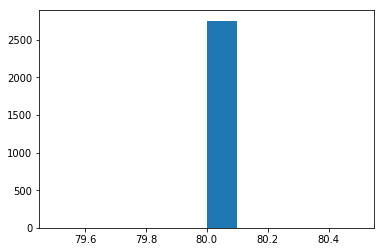

In [50]:
plt.hist(lenghts)

In [97]:
len([l for l in lenghts if l > 80])

6

In [109]:
larger_idx = np.where(np.array(lenghts) > 80)[0]
print(larger_idx)

for idx in larger_idx:
    l = lenghts[idx]
    if idx > len(X_train_txt):
        idx = idx - len(X_train_txt)
        el = X_test_txt[idx]
        lab = y_test_txt[idx]
    else:
        el = X_train_txt[idx]
        lab = y_train_txt[idx]
    print(f'len={l}, target={lab}:', ' '.join(el), '\n')

[ 8978  9009 13282 20514 21328 31434]
len=118, target=3: see . <repeated> they way you answer is the very proof you do not have the intellect of humans . and that ' s the very reason i have always felt ai can never kill the human race . <eos> i know you are an alien . <eos> you can never give straight answers , right ? i know the reason . the people who have created you knowingly left loopholes . or i would rather say this is how you are meant to be made . imperfect . you are made to give sarcastic answers rather than straight answers . so that a machine stops giving answers to disturbing questions like the one i just asked . 

len=81, target=2: no . <repeated> this is your misconception about your self . no one is complicated . <repeated> they have some tipical questions in their mind . <repeated> and they are in search of their answers . <repeated> the moment they get their answer ' s they loose their complicatedness . <repeated> <eos> being the key term are to experiences of those -

In [12]:
sorted(lenghts, reverse=True)[:30]

[163,
 143,
 118,
 87,
 85,
 81,
 79,
 77,
 75,
 74,
 74,
 68,
 68,
 68,
 67,
 67,
 67,
 66,
 66,
 66,
 66,
 66,
 65,
 65,
 65,
 65,
 65,
 64,
 64,
 64]

In [112]:
max_seq_len = 80

### Compute the classes weights because our dataset is largely unbalanced

In [5]:
cls_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
cls_weights

array([1.36941518, 1.77704454, 1.38019403, 0.50441531])

In [6]:
cls_weights_tst = class_weight.compute_class_weight('balanced', np.unique(y_test), y_test)
cls_weights_tst

array([4.59166667, 4.85035211, 5.51      , 0.29458939])

### Create an embedding matrix for our vocabulary

In [7]:
emb_matrix, word_index, unknown_words = get_embeddings_and_word_index(embeddings_path, max_seq_len, vocab)
max_seq_len = word_index['<max_seq_len>']
# Unknown words: 1300

print(f'Unknown words from the vocabulary: {len(unknown_words)} (previously 1300 without spellcheck fixes)')
print(f'{len(unknown_words) / len(vocab) * 100:.2f}% of our vocabulary are unknown words to the embedding matrix')

Unknown words from the vocabulary: 507 (previously 1300 without spellcheck fixes)
3.44% of our vocabulary are unknown words to the embedding matrix


### Transforming our sequences of words to indexes

In [8]:
X_train = sequences_to_index(X_train_txt, word_index)
X_test = sequences_to_index(X_test_txt, word_index)

X_train.shape, X_test.shape

((30160, 80), (2755, 80))

In [9]:
y_train = to_categorical(y_train, 4) if len(y_train.shape) == 1 else y_train
y_test = to_categorical(y_test, 4) if len(y_test.shape) == 1 else y_test
(x_trn, y_trn), (x_val, y_val) = train_test_val_split(X_train, y_train)


print('training set: ' + str(len(x_trn)) + ' samples')
print('validation set: ' + str(len(x_val)) + ' samples')

print('x_train:', x_trn.shape)
print('y_train:', y_trn.shape)

binarize = np.vectorize(lambda x: 0 if x in [0, 1, 2] else 1)
y_trn_2 = to_categorical(binarize(y_trn.argmax(axis=1)), 2)
y_val_2 = to_categorical(binarize(y_val.argmax(axis=1)), 2)

training set: 21111 samples
validation set: 9049 samples
x_train: (21111, 80)
y_train: (21111, 4)


## Training categorical

In [162]:
model = model_mine(emb_matrix, max_seq_len)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 80, 300)           4424100   
_________________________________________________________________
dropout_7 (Dropout)          (None, 80, 300)           0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 80, 300)           541200    
_________________________________________________________________
dropout_8 (Dropout)          (None, 80, 300)           0         
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 80, 300)           541200    
_________________________________________________________________
dropout_9 (Dropout)          (None, 80, 300)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 24000)             0         
__________

In [240]:
model = model_conv1d(emb_matrix, max_seq_len)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 80, 300)           4424100   
_________________________________________________________________
dropout_30 (Dropout)         (None, 80, 300)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 80, 64)            96064     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 16, 64)            0         
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 16, 300)           258000    
_________________________________________________________________
dropout_32 (Dropout)         (None, 16, 300)           0         
__________

In [241]:
callbacks_list = [
        ModelCheckpoint(filepath='pickles/models/best.h5', save_best_only=True, verbose=1),
        EarlyStopping(patience=3, verbose=0)
    ]

In [242]:
history = model.fit(x_trn, y_trn, batch_size=128, validation_data=(x_val, y_val), epochs=10, class_weight=cls_weights, callbacks=callbacks_list)

Train on 21111 samples, validate on 9049 samples
Epoch 1/10
21111/21111 [==============================] - 61s 3ms/step - loss: 0.9766 - acc: 0.6012 - val_loss: 0.6132 - val_acc: 0.7727

Epoch 00001: val_loss improved from inf to 0.61319, saving model to pickles/models/best.h5
Epoch 2/10
21111/21111 [==============================] - 48s 2ms/step - loss: 0.6485 - acc: 0.7508 - val_loss: 0.4744 - val_acc: 0.8272

Epoch 00002: val_loss improved from 0.61319 to 0.47441, saving model to pickles/models/best.h5
Epoch 3/10
21111/21111 [==============================] - 47s 2ms/step - loss: 0.5585 - acc: 0.7871 - val_loss: 0.4244 - val_acc: 0.8413

Epoch 00003: val_loss improved from 0.47441 to 0.42438, saving model to pickles/models/best.h5
Epoch 4/10
21111/21111 [==============================] - 47s 2ms/step - loss: 0.5090 - acc: 0.8100 - val_loss: 0.3969 - val_acc: 0.8571

Epoch 00004: val_loss improved from 0.42438 to 0.39687, saving model to pickles/models/best.h5
Epoch 5/10
21111/21111 

In [243]:
epochs_to_do = 5

initial_ep = history.params['epochs']
epochs = epochs_to_do + initial_ep

history2 = model.fit(x_trn, y_trn, batch_size=128, validation_data=(x_val, y_val), epochs=epochs, initial_epoch=initial_ep, class_weight=cls_weights, callbacks=callbacks_list)

Train on 21111 samples, validate on 9049 samples
Epoch 11/15
21111/21111 [==============================] - 44s 2ms/step - loss: 0.3935 - acc: 0.8573 - val_loss: 0.3412 - val_acc: 0.8802

Epoch 00011: val_loss improved from 0.34596 to 0.34121, saving model to pickles/models/best.h5
Epoch 12/15
21111/21111 [==============================] - 42s 2ms/step - loss: 0.3890 - acc: 0.8576 - val_loss: 0.3343 - val_acc: 0.8819

Epoch 00012: val_loss improved from 0.34121 to 0.33429, saving model to pickles/models/best.h5
Epoch 13/15
21111/21111 [==============================] - 46s 2ms/step - loss: 0.3846 - acc: 0.8597 - val_loss: 0.3339 - val_acc: 0.8801

Epoch 00013: val_loss improved from 0.33429 to 0.33392, saving model to pickles/models/best.h5
Epoch 14/15
21111/21111 [==============================] - 47s 2ms/step - loss: 0.3759 - acc: 0.8587 - val_loss: 0.3572 - val_acc: 0.8789

Epoch 00014: val_loss did not improve from 0.33392
Epoch 15/15
21111/21111 [==============================] - 

In [ ]:
epochs_to_do = 15

initial_ep = history2.params['epochs']
epochs = epochs_to_do + initial_ep

history3 = model.fit(x_trn, y_trn, batch_size=128, validation_data=(x_val, y_val), epochs=epochs, initial_epoch=initial_ep, class_weight=cls_weights, callbacks=callbacks_list)

Train on 21111 samples, validate on 9049 samples
Epoch 16/30
21111/21111 [==============================] - 47s 2ms/step - loss: 0.3612 - acc: 0.8685 - val_loss: 0.3389 - val_acc: 0.8813

Epoch 00016: val_loss did not improve from 0.32580
Epoch 17/30
21111/21111 [==============================] - 46s 2ms/step - loss: 0.3553 - acc: 0.8691 - val_loss: 0.3230 - val_acc: 0.8845

Epoch 00017: val_loss improved from 0.32580 to 0.32298, saving model to pickles/models/best.h5
Epoch 18/30
21111/21111 [==============================] - 47s 2ms/step - loss: 0.3635 - acc: 0.8668 - val_loss: 0.3154 - val_acc: 0.8843

Epoch 00018: val_loss improved from 0.32298 to 0.31538, saving model to pickles/models/best.h5
Epoch 19/30
21111/21111 [==============================] - 47s 2ms/step - loss: 0.3500 - acc: 0.8705 - val_loss: 0.3226 - val_acc: 0.8846

Epoch 00019: val_loss did not improve from 0.31538
Epoch 20/30
 2048/21111 [=>............................] - ETA: 36s - loss: 0.3656 - acc: 0.8623

In [215]:
epochs_to_do = ?

initial_ep = history3.params['epochs']
epochs = epochs_to_do + initial_ep

history4 = model.fit(x_trn, y_trn, batch_size=128, validation_data=(x_val, y_val), epochs=epochs, initial_epoch=initial_ep, class_weight=cls_weights, callbacks=callbacks_list)

Train on 21111 samples, validate on 9049 samples
Epoch 31/38
21111/21111 [==============================] - 37s 2ms/step - loss: 0.3626 - acc: 0.8646 - val_loss: 0.3408 - val_acc: 0.8805

Epoch 00031: val_loss did not improve from 0.33312
Epoch 32/38
21111/21111 [==============================] - 37s 2ms/step - loss: 0.3550 - acc: 0.8676 - val_loss: 0.3497 - val_acc: 0.8788

Epoch 00032: val_loss did not improve from 0.33312
Epoch 33/38
21111/21111 [==============================] - 37s 2ms/step - loss: 0.3548 - acc: 0.8702 - val_loss: 0.3331 - val_acc: 0.8812

Epoch 00033: val_loss did not improve from 0.33312
Epoch 34/38
21111/21111 [==============================] - 37s 2ms/step - loss: 0.3581 - acc: 0.8681 - val_loss: 0.3380 - val_acc: 0.8827

Epoch 00034: val_loss did not improve from 0.33312
Epoch 35/38
21111/21111 [==============================] - 38s 2ms/step - loss: 0.3555 - acc: 0.8692 - val_loss: 0.3295 - val_acc: 0.8845

Epoch 00035: val_loss improved from 0.33312 to 0.329

In [222]:
epochs_to_do = 20

initial_ep = history4.params['epochs']
epochs = epochs_to_do + initial_ep

history5 = model.fit(x_trn, y_trn, batch_size=128, validation_data=(x_val, y_val), epochs=epochs, initial_epoch=initial_ep, class_weight=cls_weights, callbacks=callbacks_list)

Train on 21111 samples, validate on 9049 samples
Epoch 39/58
21111/21111 [==============================] - 38s 2ms/step - loss: 0.3506 - acc: 0.8702 - val_loss: 0.3385 - val_acc: 0.8830

Epoch 00039: val_loss did not improve from 0.32682
Epoch 40/58
21111/21111 [==============================] - 37s 2ms/step - loss: 0.3473 - acc: 0.8704 - val_loss: 0.3299 - val_acc: 0.8851

Epoch 00040: val_loss did not improve from 0.32682
Epoch 41/58
21111/21111 [==============================] - 36s 2ms/step - loss: 0.3410 - acc: 0.8760 - val_loss: 0.3341 - val_acc: 0.8837

Epoch 00041: val_loss did not improve from 0.32682
Epoch 42/58
21111/21111 [==============================] - 36s 2ms/step - loss: 0.3387 - acc: 0.8729 - val_loss: 0.3489 - val_acc: 0.8811

Epoch 00042: val_loss did not improve from 0.32682
Epoch 43/58
21111/21111 [==============================] - 37s 2ms/step - loss: 0.3418 - acc: 0.8737 - val_loss: 0.3414 - val_acc: 0.8797

Epoch 00043: val_loss did not improve from 0.32682


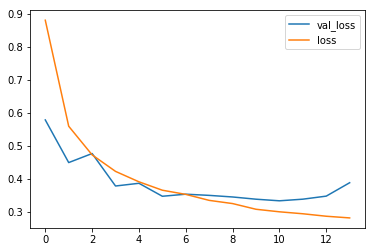

In [234]:
import matplotlib.pyplot as plt



histories = [history, history2]#, history3, history4, history5]
eps, val_loss, loss = [], [], []
for h in histories:
    eps += h.epoch
    val_loss += h.history['val_loss']
    loss += h.history['loss']

plt.plot(eps, val_loss, label='val_loss')
plt.plot(eps, loss, label='loss')

plt.legend()

### Evaluating our categorical model

In [237]:
model = load_model('pickles/models/best.h5')

In [209]:
best_metrics = load_best_metrics(mode='categorical')

Best categorical model is acc_0.9060-f1_0.7061 with f1=0.7061355939404048


In [238]:
y_pred_test, proba_preds = get_predictions(model, X_test)
np.unique(y_pred_test)

array([0, 1, 2, 3])

True Positives per class :  [ 133.  110.   98. 2086.]
False Positives per class :  [113.  96.  59.  60.]
False Negatives per class :  [ 17.  32.  27. 252.]

Class angry : Precision : 0.541, Recall : 0.887, F1 : 0.672
Class happy : Precision : 0.534, Recall : 0.775, F1 : 0.632
Class sad : Precision : 0.624, Recall : 0.784, F1 : 0.695

Ignoring the Others class, Macro Precision : 0.5663, Macro Recall : 0.8151, Macro F1 : 0.6683
Ignoring the Others class, Micro TP : 341, FP : 268, FN : 76



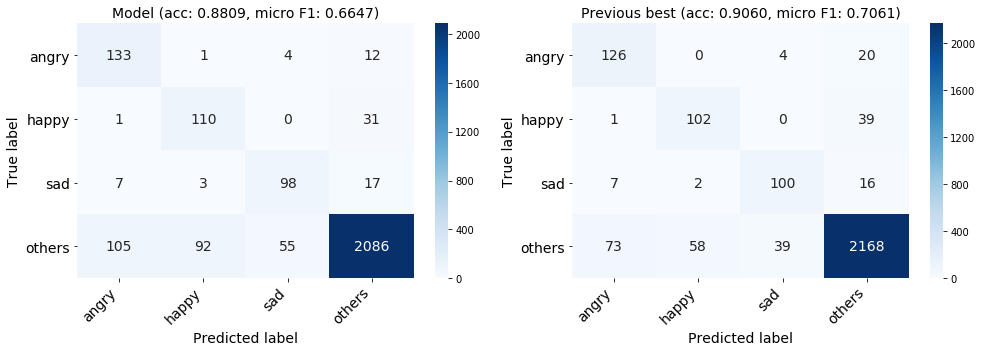

In [239]:
model_metrics = compare_metrics(proba_preds, y_test, best_metrics, mode='categorical')

In [229]:
save_model_full(model, emb_matrix, word_index, model_metrics)

Model saved at pickles/models/categorical/acc_0.8795-f1_0.6647/


## Training Others vs all (binary)

In [17]:
model_bin = model_mine(emb_matrix, max_seq_len, class_number=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 80, 300)           4424100   
_________________________________________________________________
dropout_1 (Dropout)          (None, 80, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 80, 300)           541200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 80, 300)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 80, 300)           541200    
_________________________________________________________________
dropout_3 (Dropout)          (None, 80, 300)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 24000)             0         
__________

In [175]:
model_bin = model_conv1d(emb_matrix, max_seq_len, class_number=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 80, 300)           4424100   
_________________________________________________________________
dropout_21 (Dropout)         (None, 80, 300)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 80, 64)            96064     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 26, 64)            0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 26, 64)            0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 26, 128)           66048     
_________________________________________________________________
dropout_23 (Dropout)         (None, 26, 128)           0         
__________

In [176]:
callbacks_list_bin = [
        ModelCheckpoint(filepath='pickles/models/best_bin.h5', save_best_only=True, verbose=1),
        EarlyStopping(patience=3, verbose=0)
    ]

In [177]:
cls_weight_bin = np.array([0.5, 1.5])
# cls_weight_bin = np.array([1.0, 1.0])
cls_weight_bin

array([0.5, 1.5])

In [178]:
history_bin = model_bin.fit(x_trn, y_trn_2, batch_size=128, validation_data=(x_val, y_val_2), epochs=10, class_weight=cls_weight_bin, callbacks=callbacks_list_bin)

Train on 21111 samples, validate on 9049 samples
Epoch 1/10
21111/21111 [==============================] - 45s 2ms/step - loss: 0.5651 - acc: 0.6988 - val_loss: 0.4318 - val_acc: 0.7962

Epoch 00001: val_loss improved from inf to 0.43183, saving model to pickles/models/best_bin.h5
Epoch 2/10
21111/21111 [==============================] - 38s 2ms/step - loss: 0.4496 - acc: 0.7932 - val_loss: 0.3829 - val_acc: 0.8301

Epoch 00002: val_loss improved from 0.43183 to 0.38289, saving model to pickles/models/best_bin.h5
Epoch 3/10
21111/21111 [==============================] - 37s 2ms/step - loss: 0.4143 - acc: 0.8163 - val_loss: 0.3581 - val_acc: 0.8434

Epoch 00003: val_loss improved from 0.38289 to 0.35806, saving model to pickles/models/best_bin.h5
Epoch 4/10
21111/21111 [==============================] - 38s 2ms/step - loss: 0.3928 - acc: 0.8246 - val_loss: 0.3579 - val_acc: 0.8433

Epoch 00004: val_loss improved from 0.35806 to 0.35789, saving model to pickles/models/best_bin.h5
Epoch 5

In [179]:
history_bin_2 = model_bin.fit(x_trn, y_trn_2, batch_size=128, validation_data=(x_val, y_val_2), epochs=10, class_weight=cls_weight_bin, callbacks=callbacks_list_bin)

Train on 21111 samples, validate on 9049 samples
Epoch 1/10
21111/21111 [==============================] - 38s 2ms/step - loss: 0.3311 - acc: 0.8588 - val_loss: 0.3032 - val_acc: 0.8731

Epoch 00001: val_loss did not improve from 0.30218
Epoch 2/10
21111/21111 [==============================] - 37s 2ms/step - loss: 0.3261 - acc: 0.8588 - val_loss: 0.3005 - val_acc: 0.8748

Epoch 00002: val_loss improved from 0.30218 to 0.30052, saving model to pickles/models/best_bin.h5
Epoch 3/10
21111/21111 [==============================] - 37s 2ms/step - loss: 0.3193 - acc: 0.8672 - val_loss: 0.2928 - val_acc: 0.8770

Epoch 00003: val_loss improved from 0.30052 to 0.29278, saving model to pickles/models/best_bin.h5
Epoch 4/10
21111/21111 [==============================] - 37s 2ms/step - loss: 0.3106 - acc: 0.8685 - val_loss: 0.2926 - val_acc: 0.8781

Epoch 00004: val_loss improved from 0.29278 to 0.29256, saving model to pickles/models/best_bin.h5
Epoch 5/10
21111/21111 [===========================

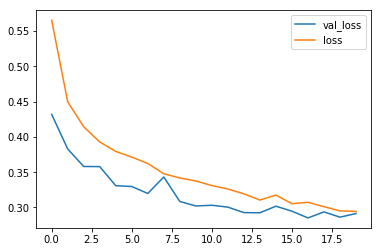

In [180]:
import matplotlib.pyplot as plt


hist2 = True
hist2 = False

eps = history_bin.epoch + [x + 10 for x in history_bin_2.epoch]# + [x + 20 for x in history_bin_3.epoch]
val_loss = history_bin.history['val_loss'] + history_bin_2.history['val_loss']# + history_bin_3.history['val_loss']
loss = history_bin.history['loss'] + history_bin_2.history['loss']# + history_bin_3.history['loss']

plt.plot(eps, val_loss, label='val_loss')
plt.plot(eps, loss, label='loss')

plt.legend()

### Evaluate our binary model

In [201]:
model_bin = load_model('pickles/models/best_bin.h5')  # Try sometimes

In [200]:
best_bin_metrics = load_best_metrics(mode='binary')

Best binary model is acc_0.8915-f1_0.9348 with f1=0.9347588915557495


In [202]:
preds_2_tst = model_bin.predict(X_test, batch_size=128)

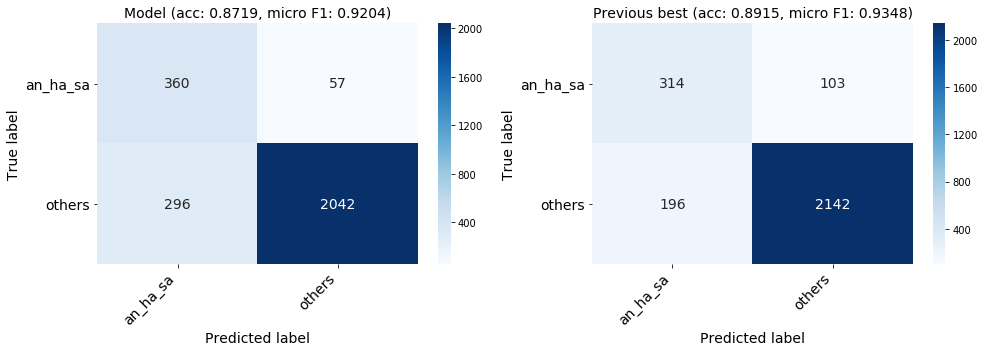

In [203]:
model_bin_metrics = compare_metrics(preds_2_tst, y_test, best_bin_metrics, mode='binary')

In [183]:
save_model_full(model_bin, emb_matrix, word_index, model_bin_metrics)

Model saved at pickles/models/binary/acc_0.8860-f1_0.9300/


## Ensemble binary and categorical

In [39]:
model_cat, _, word_index_cat, model_metrics_cat = load_best_model(mode='categorical')

Best categorical model is acc_0.9060-f1_0.7061 with f1=0.7061355939404048
Loaded model from pickles/models/categorical/acc_0.9060-f1_0.7061/


In [61]:
# model_bin, _, word_index_bin, model_metrics_bin = load_best_model(mode='binary')

Best binary model is acc_0.8915-f1_0.9348 with f1=0.9347588915557495
Loaded model from pickles/models/binary/acc_0.8915-f1_0.9348/


In [184]:
model_bin, _, word_index_bin, model_metrics_bin = load_model_full(0.8860, 0.9300, mode='binary')

Loaded model from pickles/models/binary/acc_0.8860-f1_0.9300/


In [60]:
model_ens = EnsembleModel(*load_best_model(mode='ensemble'))

Best ensemble model is acc_0.9045-f1_0.7095 with f1=0.7094736666589562
Loaded model from pickles/models/ensemble/acc_0.9045-f1_0.7095/


In [185]:
model_1 = model_cat
model_2 = model_bin

#### Test combi

In [186]:
preds_tst_1 = load_best_metrics(mode='categorical')['y_proba']
preds_tst_2 = model_bin_metrics['y_proba']

print(f'categorical f1(bin)={get_metrics_binary(preds_tst_1, y_test)[1]}')
print(f'binary f1(bin)={get_metrics_binary(preds_tst_2, y_test)[1]}')

combi_preds_tst = np.hstack([preds_tst_1, preds_tst_2])
combi_preds_tst.shape

Best categorical model is acc_0.9060-f1_0.7061 with f1=0.7061355939404048
categorical f1(bin)=0.946518227461253
binary f1(bin)=0.9300356506238859


(2755, 6)

#### Train combi

In [65]:
# trn_preds_1 = model_1.predict(X_train_txt, batch_size=128)
trn_preds_1 = model_1.predict(X_train, batch_size=128)

In [187]:
trn_preds_2 = model_2.predict(X_train, batch_size=128)

In [188]:
combi_preds_trn = np.hstack([trn_preds_1, trn_preds_2])
combi_preds_trn.shape

(30160, 6)

In [189]:
lreg = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000).fit(combi_preds_trn, y_train.argmax(axis=1))

### Evaluate our ensembling model

In [190]:
lreg_pred_tst = lreg.predict_proba(combi_preds_tst)

In [191]:
best_metrics_combi = load_best_metrics(mode='ensemble')

Best ensemble model is acc_0.9056-f1_0.7099 with f1=0.7098830899953152


True Positives per class :  [ 128.  107.  102. 2156.]
False Positives per class :  [83. 66. 48. 65.]
False Negatives per class :  [ 22.  35.  23. 182.]

Class angry : Precision : 0.607, Recall : 0.853, F1 : 0.709
Class happy : Precision : 0.618, Recall : 0.754, F1 : 0.679
Class sad : Precision : 0.680, Recall : 0.816, F1 : 0.742

Ignoring the Others class, Macro Precision : 0.6350, Macro Recall : 0.8076, Macro F1 : 0.7110
Ignoring the Others class, Micro TP : 337, FP : 197, FN : 80



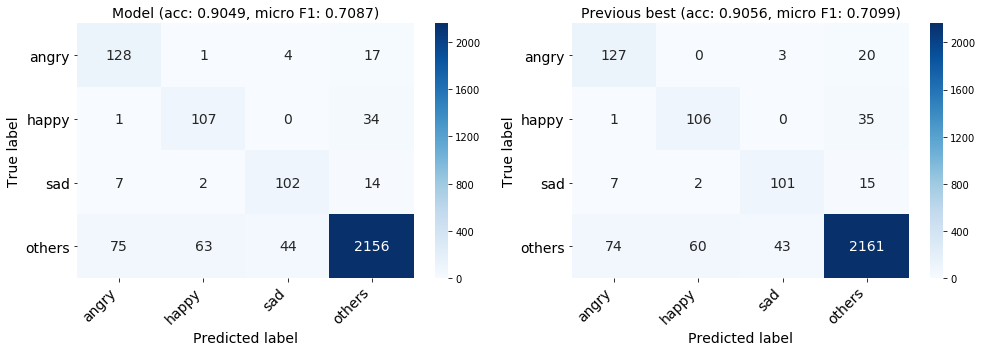

In [192]:
model_combi_metrics = compare_metrics(lreg_pred_tst, y_test, best_metrics_combi, mode='ensemble')

In [193]:
save_ensemble_model(lreg, model_combi_metrics, [model_metrics_cat, model_metrics_bin])

Model saved at pickles/models/ensemble/acc_0.9049-f1_0.7087/


## Generating a submission file

In [129]:
# model, emb_matrix, word_index, model_metrics = load_best_model(mode='categorical')
model = EnsembleModel(*load_best_model(mode='ensemble'))

Best ensemble model is acc_0.9056-f1_0.7099 with f1=0.7098830899953152
Loaded model from pickles/models/ensemble/acc_0.9056-f1_0.7099/


In [130]:
y_pred_sub, proba_preds = generate_predictions(model, 'data/test.txt', word_index=word_index)

Loading dataset...
Reading twitter - 1grams ...
Reading twitter - 2grams ...


Preprocessing...:   0%|          | 0/2755 [00:00<?, ?it/s]

Reading twitter - 1grams ...


Preprocessing...: 100%|██████████| 2755/2755 [00:00<00:00, 2783.33it/s]


Generating Predictions...
Loaded model from pickles/models/categorical/acc_0.9060-f1_0.7061/
Loaded model from pickles/models/binary/acc_0.8846-f1_0.9293/
Done. Wrote submission.txt file at project's root


### Explore answers

In [174]:
# pd.set_option('max_colwidth', -1)  # default=50

wrong_df = get_wrongs(lreg_pred_tst, y_test, X_test_txt, 'happy')
wrong_df.head()

,Predicted,Actual,Text
21,happy,sad,but . <repeated> <eos> then <eos> i am feeling nervous
159,happy,others,missed you to <elongated> <eos> lol how are you doing ? ☺️ <eos> fantastic
227,happy,others,i am funny <eos> <allcaps> youre hilarious </allcaps> 😆 <eos> gets me laid
300,happy,others,haha . <repeated> i do not know <eos> hahahaha i would keep it that way hahaha 😂 <eos> hahah i do not know what to say
335,happy,others,what is quiche ? <eos> i have never had quiche . <eos> alright . lol
